In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML  # for embedded matplotlib animation
from math import *
matplotlib.rc('animation', html='html5')

Implementation of all the function in module 10.2

Reference: https://ics.wofford-ecs.org/files-to-download


In [5]:
global AMBIENT, HOT, COLD
AMBIENT = 25.0
HOT = 50.0
COLD = 0.0

In [6]:
def initBar(m, n, hotSites, coldSites):
#   global AMBIENT
    ambientBar = AMBIENT * np.ones((m, n))
    bar = applyHotCold(ambientBar, hotSites, coldSites)
    return bar

In [7]:
def applyHotCold(bar, hotSites, coldSites):
    for k in range(len(hotSites)):
        bar[hotSites[k, 0], hotSites[k, 1]] = HOT
    for k in range(len(coldSites)):
        bar[coldSites[k, 0], coldSites[k, 1]] = COLD
    return bar

In [8]:
# def diffusion(diffusionRate, site, N, NE, E, SE, S, SW, W, NW):
#     return (1 - 8*diffusionRate)*site + diffusionRate*(N+NE+E+SE+S+SW+W+NW)

In [47]:
def weighted_diff(diffusionRate, site, N, NE, E, SE, S, SW, W, NW):
  sites = np.empty(8)
  sites.fill(site)
  neighbour = np.array([N, NE, E, SE, S, SW, W, NW])
  weights = diffusionRate
  return (1/4)*site + np.dot(weights, (neighbour - sites))

In [10]:
def reflectingLat(lat):
    latNS = np.row_stack((lat[0], lat, lat[-1]))
    return np.column_stack((latNS[:,0], latNS, latNS[:,-1]))

In [11]:
def applyDiffusionExtended(diffusionRate, latExt):
    m = latExt.shape[0] - 2
    n = latExt.shape[1] - 2
    newLat = np.zeros((m, n))

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            site = latExt[i, j]
            N = latExt[i - 1, j]
            NE = latExt[i - 1, j + 1]
            E = latExt[i, j + 1]
            SE = latExt[i + 1, j + 1]
            S = latExt[i + 1, j]
            SW = latExt[i + 1, j - 1]
            W = latExt[i, j - 1]
            NW = latExt[i - 1, j - 1]
            newLat[i - 1, j - 1] = diffusion(diffusionRate, site, N, NE, E, SE, S, SW, W, NW);
    return newLat

In [12]:
def  diffusionSim(m, n, diffusionRate, hotSites, coldSites, t, boundary):
    # Initialize grid
    bar = initBar(m, n, hotSites, coldSites)

    # Perform simulation
    grids = np.zeros((t + 1, m, n))
    grids[0, :, :] = bar
    for i in range(1, t + 1):
        # Extend matrix
        barExtended = boundary(bar)
        # Apply spread of heat function to each grid point
        bar = applyDiffusionExtended(diffusionRate, barExtended)
        # reapply hot and cold spots
        bar = applyHotCold(bar, hotSites, coldSites)
        # Save new matrix
        grids[i, :, :] = bar
    return grids

In [55]:
def animate_simulation(grids, time):
  Writer = animation.writers['ffmpeg']
  writer = Writer(fps=160, metadata=dict(artist='Me'), bitrate=1800)

  figGray = plt.figure()
  plt.axis('off')
  imGray = plt.imshow(grids[0,:,:], cmap='gray', interpolation='nearest', animated=True)

  # The animation function, called to produce a frame for each generation.
  def updatefig(i, *args):
      global grids
      imGray.set_array(grids[i,:,:])
      return imGray,

  grid_ani = animation.FuncAnimation(figGray, updatefig, save_count = len(grids),
                                    interval=50, blit=False)
  plt.show()

  # To save the animation, use the command, placed before HTML:
  grid_ani.save('DiffusionGray.mp4', writer=writer)

  return HTML(grid_ani.to_html5_video())

In [14]:
m = 10
n = 30
# diffusionRate is rate_of_diffusion in all * direction N, NE, E, SE, S, SW, W, NW
diffusionRate = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
# diffusionRate = 0.1

hotSites = np.array([[floor(m/2),0],[floor(m/2)+1,0],[floor(m/2)+2,0],
                    [0,floor(m/2)]])
coldSites = np.array([[m-1,floor(n/3)-2],[m-1,floor(n/3)-1],
                        [m-1,floor(n/3)],[m-1,floor(n/3)+1],
                         [m-1,floor(n/3)+2]])
t = 200

In [15]:
print(hotSites, coldSites)

[[5 0]
 [6 0]
 [7 0]
 [0 5]] [[ 9  8]
 [ 9  9]
 [ 9 10]
 [ 9 11]
 [ 9 12]]


White cells are hotSites and Black cells are coldSites

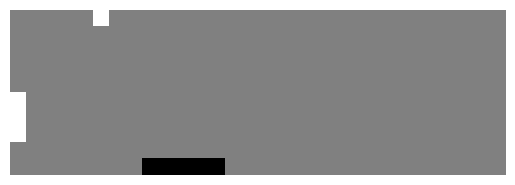

In [16]:
# Simple simulation of Heat Diffusion using above parameters
grids = diffusionSim(m, n, diffusionRate, hotSites, coldSites, t, reflectingLat)
animate_simulation(grids, t)

1.

a. Determine how long it takes, t, for the bar modeled in this module to reach
equilibrium, where from time t to time t + 1 the values in each cell vary by
no more than plus or minus some small value, such as ±0.001.

In [17]:
def diffusion_equilibrium(m, n, diffusionRate, hotSites, coldSites, boundary):
    # Initialize grid
    bar = initBar(m, n, hotSites, coldSites)

    # Perform simulation
    grids = np.zeros((2, m, n))
    grids[1, :, :] = bar
    grids[0, :, :] = np.zeros((m, n))
    i = 1
    while not np.allclose(grids[i, :, :], grids[i-1, :, :], 1e-3):
        # Extend matrix
        barExtended = boundary(bar)
        # Apply spread of heat function to each grid point
        bar = applyDiffusionExtended(diffusionRate, barExtended)
        # reapply hot and cold spots
        bar = applyHotCold(bar, hotSites, coldSites)
        # Save new matrix
        grids = np.vstack((grids, [bar]))
        # print(i)
        i+=1
    return grids[1:,:,:], i

133


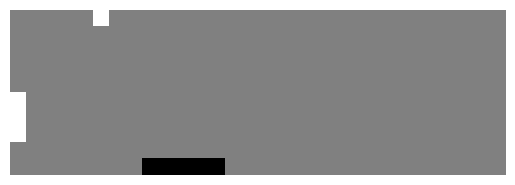

In [18]:
grids, time = diffusion_equilibrium(m, n, diffusionRate, hotSites, coldSites, reflectingLat)
print(time)
animate_simulation(grids, time)
# print(grids[time - 1,:,:])

b. Repeat Part a, applying heat and cold for 10 time steps and then removing
such heating and cooling.

In [19]:
def diffusion_stops(m, n, diffusionRate, hotSites, coldSites, t, boundary):
    # Initialize grid
    bar = initBar(m, n, hotSites, coldSites)

    # Perform simulation
    grids = np.zeros((2, m, n))
    grids[1, :, :] = bar
    grids[0, :, :] = np.zeros((m, n))
    i = 1

    while not np.allclose(grids[i, :, :], grids[i-1, :, :], 1e-3):
        # Extend matrix
        barExtended = boundary(bar)
        # Apply spread of heat function to each grid point
        bar = applyDiffusionExtended(diffusionRate, barExtended)
        # reapply hot and cold spots
        if (i <= t):
          bar = applyHotCold(bar, hotSites, coldSites)
        # Save new matrix
        grids = np.vstack((grids, [bar]))
        # print(i)
        i+=1
    return grids[1:,:,:], i

110


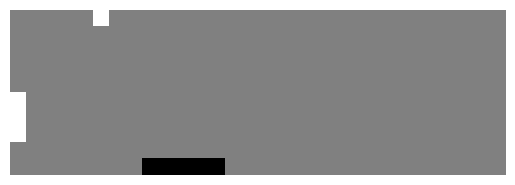

In [28]:
stop_after = 10
grids, time = diffusion_stops(m, n, diffusionRate, hotSites, coldSites, stop_after, reflectingLat)
print(time)
animate_simulation(grids, time)

2. Develop simulations and animations for the bar modeled in this module using several boundary conditions: three simulations of absorbing boundary conditions with constant values 0, 25, and 50 and periodic boundary conditions.

Along with the reflecting boundary conditions, describe the results. Discuss
the advantages and disadvantages of each approach and the situations, such
as heat or pollution diffusion, for which each is most appropriate.

In [39]:
global ABS_CONST
ABS_CONST = 25
t = 250

# global AMBIENT, HOT, COLD
# AMBIENT = 25.0
# HOT = 50.0
# COLD = 0.0

In [48]:
def absorbingLat(lat):
    col = np.full(shape=lat[0].shape,fill_value=ABS_CONST)
    latNS = np.row_stack((col, lat, col))
    row = np.full(shape=latNS[:,0].shape,fill_value=ABS_CONST)
    return np.column_stack((row, latNS, row))

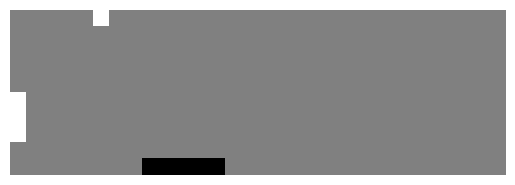

In [49]:
grids = diffusionSim(m, n, diffusionRate, hotSites, coldSites, t, absorbingLat)
animate_simulation(grids, t)

For the three cases of absorbing boundary conditions we will notice that:-

1. For 0 we will notice that the whole of the grid turns dark black because the boundaries(at lower temperature) will diffuse their heat into the grid to maintane their temperature causing all the cells to increase their temperature, except a few which are cold sites or neighbourhood of cold sites.

2. For 25 we will notice that the equilibrium does not shift much from the original value, reasoning for this is that influx and outflux of heat energy is almost equal for this temperature.

3. For 50 degree we will observe the case just opposite to the first one.

In [43]:
def periodicLat(lat): #This is the function of the boundary conditions.
    latN = np.row_stack((lat[-1], lat))
    latS = np.row_stack((latN, lat[0]))
    latE = np.column_stack((latS[:,-1], latS))
    return np.column_stack((latE, latS[:,0]))
  # why it is applied ?

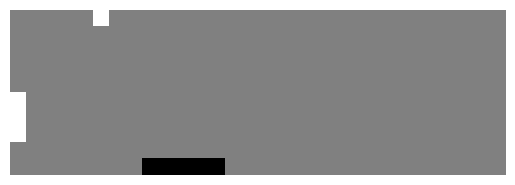

In [44]:
# grids = diffusionSim(m, n, diffusionRate, coldSites, hotSites, t, periodicLat)
grids = diffusionSim(m, n, diffusionRate, hotSites, coldSites, t, periodicLat)

animate_simulation(grids, t)

For periodic boundary conditions opposite boundaries seem alike and show the same behaviour alternatively which is like super-imposing the opposite boundaries.

3. Instead of using the formula for diffusion in the section “Heat Diffusion,”
employ the filter in Figure 10.2.13. Thus, to obtain the value at a site for time
t + 1, we add 25% of the site’s temperature at time t, 12.5% of the north, east,
south, and west cells at time t, and 6.25% of the corner cells to the northeast,
southeast, southwest, and northwest. This sum is called a weighted sum with
each nutrition value carrying a particular weight as indicated by the table.
Revise the model using this configuration and compare the results with that
of the module.

59


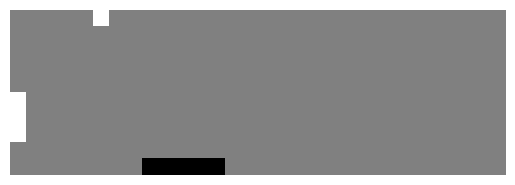

In [56]:
diffusionRate = np.array([0.125, 0.0625, 0.125, 0.0625, 0.125, 0.0625, 0.125, 0.0625])

# grids = diffusionSim(m, n, diffusionRate, hotSites, coldSites, t, reflectingLat)
# animate_simulation(grids, t)
grids, time = diffusion_equilibrium(m, n, diffusionRate, hotSites, coldSites, reflectingLat)
print(time)
animate_simulation(grids, time)

The results are very different from the initial configuration when the weights are introduced.